In [1]:
import os
from pathlib import Path
import csv
import pandas as pd
import numpy as np
from PIL import Image, ImageFilter, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import skimage.io as skio

from pathlib import Path

# === CORRECT PATH SETUP ===
ROOT = Path(r"C:\Users\LIKITHA\Downloads\dataset")

RAW_DIR    = ROOT / "raw_data"
PRE_DIR    = ROOT / "preprocessed_data"
META_DIR   = ROOT / "metadata"
REPORT_DIR = ROOT / "report"

# Create folders if they don't exist
for p in [RAW_DIR, PRE_DIR, META_DIR, REPORT_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT.resolve())
print("RAW_DIR:", RAW_DIR.resolve())

ROOT: C:\Users\LIKITHA\Downloads\dataset
RAW_DIR: C:\Users\LIKITHA\Downloads\dataset\raw_data


In [2]:
# This reads each subfolder (each representing a scanner model) and creates metadata rows.
IMG_EXTS = {'.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'}

def build_metadata_csv(raw_dir=RAW_DIR, out_csv=META_DIR/"dataset_labels.csv"):
    rows = []
    # each subfolder is a scanner label
    for scanner_folder in sorted(raw_dir.iterdir()):
        if not scanner_folder.is_dir(): 
            continue
        scanner_label = scanner_folder.name
        for f in sorted(scanner_folder.iterdir()):
            if f.suffix.lower() in IMG_EXTS:
                rows.append({
                    "scanner_model": scanner_label,
                    "file_name": str(Path(scanner_label) / f.name),
                    "original_format": f.suffix.lower().replace('.','').upper(),
                    "width": "",
                    "height": "",
                    "dpi": "",
                    "color_mode": "",
                    "notes": ""
                })
    # write CSV
    if rows:
        df = pd.DataFrame(rows)
        df.to_csv(out_csv, index=False)
        print(f"Wrote metadata for {len(df)} images to {out_csv}")
    else:
        # create empty csv skeleton
        df = pd.DataFrame(columns=["scanner_model","file_name","original_format","width","height","dpi","color_mode","notes"])
        df.to_csv(out_csv, index=False)
        print(f"No images found in {raw_dir}. Created empty skeleton at {out_csv}")
    return df

meta_df = build_metadata_csv()
meta_df.head()

Wrote metadata for 2172 images to C:\Users\LIKITHA\Downloads\dataset\metadata\dataset_labels.csv


,scanner_model,file_name,original_format,width,height,dpi,color_mode,notes
0,Cannon,Cannon\150.tif,TIF,,,,,
1,Cannon,Cannon\300.tif,TIF,,,,,
2,Cannon,Cannon\svk_id_64_000097.jpg,JPG,,,,,
3,Cannon,Cannon\svk_id_64_000103.jpg,JPG,,,,,
4,Cannon,Cannon\svk_id_64_000109.jpg,JPG,,,,,


,scanner_model,num_images
0,HP,989
1,Cannon,988
2,Epson,195


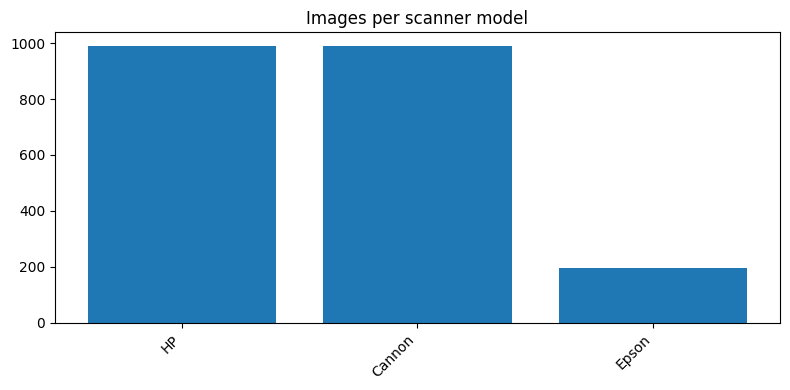

TypeError: can't multiply sequence by non-int of type 'str'

In [3]:
# 4.1 counts per scanner
counts = meta_df['scanner_model'].value_counts().reset_index()
counts.columns = ['scanner_model','num_images']
display(counts)

# Plot counts
plt.figure(figsize=(8,4))
plt.bar(counts['scanner_model'], counts['num_images'])
plt.xticks(rotation=45, ha='right')
plt.title("Images per scanner model")
plt.tight_layout()
plt.show()

# 4.2 resolution distribution
meta_df['area'] = meta_df['width'].fillna(0) * meta_df['height'].fillna(0)
plt.figure(figsize=(6,3))
plt.hist(meta_df['area'].dropna(), bins=30)
plt.title("Distribution of image area (pixels)")
plt.tight_layout()
plt.show()

# 4.3 show 1 sample per scanner
sample_rows = meta_df.groupby('scanner_model').first().reset_index()
n = len(sample_rows)
fig, axs = plt.subplots(1, n, figsize=(3*n,3))
if n==1:
    axs = [axs]
for ax, (_, r) in zip(axs, sample_rows.iterrows()):
    img_path = RAW_DIR / r['file_name']
    try:
        im = Image.open(img_path)
        ax.imshow(im)
        ax.set_title(r['scanner_model'])
    except:
        ax.text(0.5,0.5,"Missing",ha='center')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# Preprocessing config
TARGET_SIZE = (256,256)   # choose 224x224 or 256x256
DENOISE = True            # Non-local means via OpenCV if True
CROP_MARGIN = 8           # pixels to expand after auto-cropping

def crop_whitespace_pil(img_pil, border=CROP_MARGIN):
    # Detect bbox of non-white area (works well for scanned docs)
    gray = img_pil.convert("L")
    inverted = ImageOps.invert(gray)
    bbox = inverted.getbbox()
    if bbox:
        left, upper, right, lower = bbox
        left = max(0, left - border)
        upper = max(0, upper - border)
        right = min(img_pil.width, right + border)
        lower = min(img_pil.height, lower + border)
        return img_pil.crop((left, upper, right, lower))
    return img_pil

def denoise_opencv_np(np_img):
    # np_img expected as uint8 BGR or GRAY
    # Using fast Non-Local Means Denoising
    if len(np_img.shape)==3:
        return cv2.fastNlMeansDenoisingColored(np_img, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)
    else:
        return cv2.fastNlMeansDenoising(np_img, None, h=10, templateWindowSize=7, searchWindowSize=21)

def preprocess_and_save(src_path, dest_path, target_size=TARGET_SIZE, denoise=DENOISE, crop_border=CROP_MARGIN):
    img = Image.open(src_path).convert("RGB")
    # 1. Crop whitespace
    img = crop_whitespace_pil(img, border=crop_border)
    # 2. Resize (preserve aspect ratio by padding)
    img.thumbnail(target_size, Image.BICUBIC)
    # pad to exact size (center)
    new_im = Image.new("RGB", target_size, (255,255,255))
    x = (target_size[0] - img.width) // 2
    y = (target_size[1] - img.height) // 2
    new_im.paste(img, (x,y))
    # 3. Denoise (optional) via OpenCV
    if denoise:
        arr = cv2.cvtColor(np.array(new_im), cv2.COLOR_RGB2BGR)
        den = denoise_opencv_np(arr)
        den = cv2.cvtColor(den, cv2.COLOR_BGR2RGB)
        final = Image.fromarray(den)
    else:
        final = new_im
    dest_path.parent.mkdir(parents=True, exist_ok=True)
    final.save(dest_path, format='PNG')
    return dest_path

In [5]:
from tqdm import tqdm

def preprocess_all():
    for folder in RAW_DIR.iterdir():
        if folder.is_dir():
            scanner = folder.name
            print(f"\nProcessing → {scanner}")

            out_dir = PRE_DIR / scanner
            out_dir.mkdir(parents=True, exist_ok=True)

            img_files = (
                list(folder.glob("*.jpg")) +
                list(folder.glob("*.jpeg")) +
                list(folder.glob("*.png")) +
                list(folder.glob("*.tif")) +
                list(folder.glob("*.bmp"))
            )

            for img_path in tqdm(img_files):
                try:
                    dest_path = out_dir / (img_path.stem + ".png")
                    preprocess_and_save(img_path, dest_path)
                except Exception as e:
                    print(f"❌ Skipped: {img_path} — {e}")

    print("\n✔ Preprocessing completed.")

In [8]:
preprocess_all()


Processing → Cannon


100%|████████████████████████████████████████████████████████████████████████████████| 988/988 [09:25<00:00,  1.75it/s]



Processing → Epson


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [02:05<00:00,  1.55it/s]



Processing → HP


100%|████████████████████████████████████████████████████████████████████████████████| 989/989 [09:25<00:00,  1.75it/s]


✔ Preprocessing completed.


In [19]:
# Read metadata
meta_df = pd.read_csv(META_DIR/"dataset_labels.csv")

pre_rows=[]
rows = []
for idx, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc="Preprocessing images"):
    src = RAW_DIR / row['file_name']
    scanner_label = row['scanner_model']
    dest = PRE_DIR / scanner_label / (Path(row['file_name']).stem + "_pre.png")
    try:
        outpath = preprocess_and_save(src, dest)
        pre_rows.append({
            "scanner_model": scanner_label,
            "orig_file_name": row['file_name'],
            "pre_file_name": str(Path(scanner_label) / outpath.name),
            "width": TARGET_SIZE[0],
            "height": TARGET_SIZE[1],
            "format": "PNG"
        })
    except Exception as e:
        print("Failed:", src, "->", e)

# Save preprocessed metadata
pre_df = pd.DataFrame(pre_rows)
pre_df.to_csv(META_DIR/"preprocessed_labels.csv", index=False)
print("Preprocessed images:", len(pre_df))

Preprocessing images: 100%|████████████████████████████████████████████████████████| 2172/2172 [20:03<00:00,  1.80it/s]

Preprocessed images: 2172


In [20]:
# Check we can open all preprocessed images
bad = []
for p in (PRE_DIR).rglob("."):
    if p.suffix.lower() not in ['.png','.jpg','.jpeg','.tif','.tiff']:
        continue
    try:
        with Image.open(p) as im:
            im.verify()  # will raise if corrupted
    except Exception as e:
        bad.append(str(p))
if bad:
    print("Corrupted files:", bad[:10])
else:
    print("All preprocessed images opened successfully.")

All preprocessed images opened successfully.


In [21]:
# Counts per scanner in preprocessed data
pre_counts = pre_df['scanner_model'].value_counts().reset_index()
pre_counts.columns = ['scanner_model','num_images']
display(pre_counts)

# Suggest train/val/test split (stratified)
def suggest_split(df, test_size=0.2, val_size=0.1):
    # returns counts per split per class (rounded)
    out = []
    for _, r in df.iterrows():
        n = int(r['num_images'])
        t = max(1, int(n * (1 - test_size - val_size)))
        v = max(0, int(n * val_size))
        te = max(0, n - t - v)
        out.append({"scanner_model": r['scanner_model'], "train": t, "val": v, "test": te})
    return pd.DataFrame(out)

split_suggestion = suggest_split(pre_counts)
display(split_suggestion)
split_suggestion.to_csv(REPORT_DIR/"split_suggestion.csv", index=False)
print("Saved split suggestion to", REPORT_DIR/"split_suggestion.csv")

,scanner_model,num_images
0,HP,989
1,Cannon,988
2,Epson,195


,scanner_model,train,val,test
0,HP,692,98,199
1,Cannon,691,98,199
2,Epson,136,19,40


Saved split suggestion to C:\Users\LIKITHA\Downloads\dataset\report\split_suggestion.csv


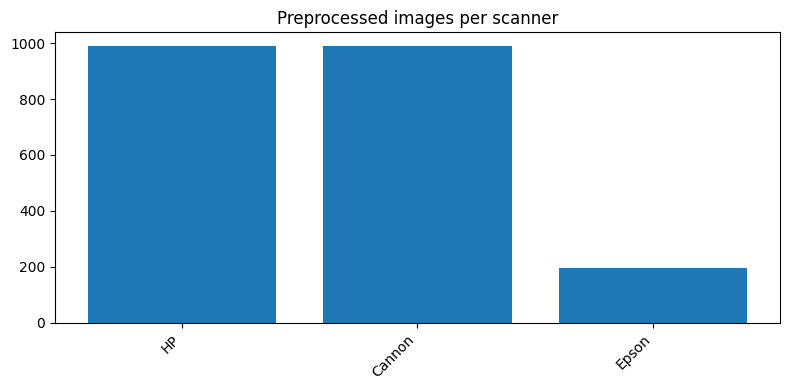

Saved report files to: C:\Users\LIKITHA\Downloads\dataset\report


In [22]:
# Save metadata copies for submission
meta_df.to_csv(META_DIR/"dataset_labels_enriched.csv", index=False)
pre_df.to_csv(META_DIR/"preprocessed_labels.csv", index=False)

# Save counts plot
plt.figure(figsize=(8,4))
plt.bar(pre_counts['scanner_model'], pre_counts['num_images'])
plt.xticks(rotation=45, ha='right')
plt.title("Preprocessed images per scanner")
plt.tight_layout()
plt.savefig(REPORT_DIR/"preprocessed_counts.png", dpi=150)
plt.show()

print("Saved report files to:", REPORT_DIR.resolve())

In [23]:
# Count images quickly from folders
def count_images(root=RAW_DIR):
    res = {}
    for folder in root.iterdir():
        if not folder.is_dir(): continue
        res[folder.name] = sum(1 for _ in folder.glob("*") if _.suffix.lower() in IMG_EXTS)
    return res

print("Raw counts:", count_images(RAW_DIR))
print("Preprocessed counts:", count_images(PRE_DIR))

Raw counts: {'Cannon': 988, 'Epson': 195, 'HP': 989}
Preprocessed counts: {'Cannon': 1976, 'Epson': 390, 'HP': 1979}


In [46]:
import os
from pathlib import Path
from PIL import Image
import pandas as pd

# Path to processed data
PROCESSED_DIR = Path(r"C:/Users/LIKITHA/Downloads/dataset/processed_data")
CSV_PATH = PROCESSED_DIR / "metadata.csv"


def extract_metadata(img_path):
    """Extract metadata from an image file."""
    try:
        with Image.open(img_path) as img:
            width, height = img.size
            dpi = img.info.get("dpi", (None, None))[0]
            mode = img.mode
            fmt = img.format
    except Exception as e:
        return {
            "scanner_model": img_path.parent.name,
            "file_name": img_path.name,
            "original_format": "UNREADABLE",
            "width": None,
            "height": None,
            "dpi": None,
            "color_mode": None,
            "notes": f"Error: {e}"
        }

    return {
        "scanner_model": img_path.parent.name,
        "file_name": img_path.name,
        "original_format": fmt,
        "width": width,
        "height": height,
        "dpi": dpi,
        "color_mode": mode,
        "notes": ""
    }


def build_metadata_csv():
    """Scan all processed images and build metadata CSV."""
    rows = []

    for folder in ["Canon", "Epson", "HP"]:
        folder_path = PROCESSED_DIR / folder
        if not folder_path.exists():
            print(f"⚠ Folder missing: {folder}")
            continue

        for img_file in folder_path.glob("*"):
            rows.append(extract_metadata(img_file))

    df = pd.DataFrame(rows)
    df.to_csv(CSV_PATH, index=False)

    print(f"\n📌 metadata.csv created at: {CSV_PATH}")
    return df

In [47]:
metadata = build_metadata_csv()
metadata.head()


📌 metadata.csv created at: C:\Users\LIKITHA\Downloads\dataset\processed_data\metadata.csv


,scanner_model,file_name,original_format,width,height,dpi,color_mode,notes
0,Canon,150.png,PNG,256,256,None,RGB,
1,Canon,150_pre.png,PNG,256,256,None,RGB,
2,Canon,300.png,PNG,256,256,None,RGB,
3,Canon,300_pre.png,PNG,256,256,None,RGB,
4,Canon,svk_id_64_000097.png,PNG,256,256,None,RGB,


In [48]:
import pandas as pd

CSV_PATH = Path(r"C:/Users/LIKITHA/Downloads/dataset/processed_data/metadata.csv")

df = pd.read_csv(CSV_PATH)

print("Total images:", len(df))
print("\nCounts by scanner:")
print(df["scanner_model"].value_counts())

print("\nProblems:")

print("\n❌ Corrupted or unreadable images:")
display(df[df["original_format"] == "UNREADABLE"])

print("\n❌ Missing DPI:")
display(df[df["dpi"].isna()])

print("\n❌ Very small or blank images:")
display(df[(df["width"] < 1000) | (df["height"] < 1000)])

print("\n❌ Non-RGB images:")
display(df[df["color_mode"] != "RGB"])

Total images: 4345

Counts by scanner:
scanner_model
HP       1979
Canon    1976
Epson     390
Name: count, dtype: int64

Problems:

❌ Corrupted or unreadable images:


,scanner_model,file_name,original_format,width,height,dpi,color_mode,notes



❌ Missing DPI:


,scanner_model,file_name,original_format,width,height,dpi,color_mode,notes
0,Canon,150.png,PNG,256,256,NaN,RGB,NaN
1,Canon,150_pre.png,PNG,256,256,NaN,RGB,NaN
2,Canon,300.png,PNG,256,256,NaN,RGB,NaN
3,Canon,300_pre.png,PNG,256,256,NaN,RGB,NaN
4,Canon,svk_id_64_000097.png,PNG,256,256,NaN,RGB,NaN
...,...,...,...,...,...,...,...,...
4340,HP,fin_id_04_000085_pre.png,PNG,256,256,NaN,RGB,NaN
4341,HP,fin_id_04_000091.png,PNG,256,256,NaN,RGB,NaN
4342,HP,fin_id_04_000091_pre.png,PNG,256,256,NaN,RGB,NaN
4343,HP,fin_id_04_000097.png,PNG,256,256,NaN,RGB,NaN



❌ Very small or blank images:


,scanner_model,file_name,original_format,width,height,dpi,color_mode,notes
0,Canon,150.png,PNG,256,256,NaN,RGB,NaN
1,Canon,150_pre.png,PNG,256,256,NaN,RGB,NaN
2,Canon,300.png,PNG,256,256,NaN,RGB,NaN
3,Canon,300_pre.png,PNG,256,256,NaN,RGB,NaN
4,Canon,svk_id_64_000097.png,PNG,256,256,NaN,RGB,NaN
...,...,...,...,...,...,...,...,...
4340,HP,fin_id_04_000085_pre.png,PNG,256,256,NaN,RGB,NaN
4341,HP,fin_id_04_000091.png,PNG,256,256,NaN,RGB,NaN
4342,HP,fin_id_04_000091_pre.png,PNG,256,256,NaN,RGB,NaN
4343,HP,fin_id_04_000097.png,PNG,256,256,NaN,RGB,NaN



❌ Non-RGB images:


,scanner_model,file_name,original_format,width,height,dpi,color_mode,notes


Images per scanner model:


<Axes: xlabel='scanner_model'>

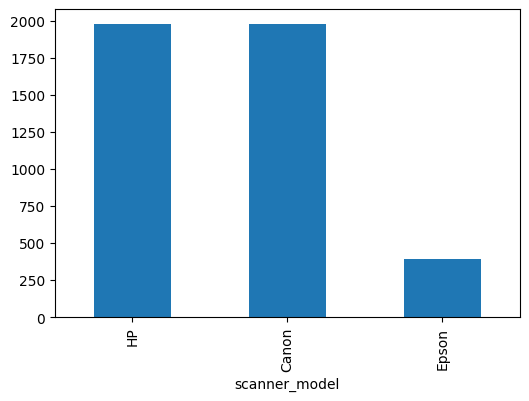

In [49]:
print("Images per scanner model:")
df["scanner_model"].value_counts().plot(kind="bar", figsize=(6,4))

In [50]:
from PIL import Image
import numpy as np
import pandas as pd

def extract_features(image_path):
    """Extract simple numerical features from an image."""
    img = Image.open(image_path).convert("RGB")
    arr = np.array(img)

    # Mean and std color in RGB channels
    mean_color = arr.mean(axis=(0,1))
    std_color = arr.std(axis=(0,1))

    # Brightness and contrast
    brightness = arr.mean()
    contrast = arr.std()

    return {
        "mean_r": float(mean_color[0]),
        "mean_g": float(mean_color[1]),
        "mean_b": float(mean_color[2]),
        "std_r": float(std_color[0]),
        "std_g": float(std_color[1]),
        "std_b": float(std_color[2]),
        "brightness": float(brightness),
        "contrast": float(contrast),
    }

In [51]:
import os
from pathlib import Path

PROCESSED_DIR = Path("C:/Users/LIKITHA/Downloads/dataset/processed_data")

feature_rows = []

for scanner in ["Canon", "Epson", "HP"]:
    folder = PROCESSED_DIR / scanner
    if not folder.exists():
        print(f"⚠ Missing folder: {folder}")
        continue

    for img_file in folder.glob("*.png"):
        try:
            features = extract_features(img_file)
            features["scanner_model"] = scanner
            features["file_name"] = img_file.name
            feature_rows.append(features)
        except Exception as e:
            print(f"❌ Error reading {img_file}: {e}")

# Convert to DataFrame
features_df = pd.DataFrame(feature_rows)
features_df.head()

,mean_r,mean_g,mean_b,std_r,std_g,std_b,brightness,contrast,scanner_model,file_name
0,253.916473,253.916473,253.916473,0.587118,0.587118,0.587118,253.916473,0.587118,Canon,150.png
1,253.916473,253.916473,253.916473,0.587118,0.587118,0.587118,253.916473,0.587118,Canon,150_pre.png
2,253.917816,253.917816,253.917816,0.588398,0.588398,0.588398,253.917816,0.588398,Canon,300.png
3,253.917816,253.917816,253.917816,0.588398,0.588398,0.588398,253.917816,0.588398,Canon,300_pre.png
4,162.704605,154.592957,154.697723,92.207364,95.474526,96.570274,157.331762,94.844975,Canon,svk_id_64_000097.png


In [52]:
FEATURES_CSV = Path("C:/Users/LIKITHA/Downloads/dataset/features.csv")

features_df.to_csv(FEATURES_CSV, index=False)

print("✅ features.csv saved at:", FEATURES_CSV)

✅ features.csv saved at: C:\Users\LIKITHA\Downloads\dataset\features.csv


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load the CSV
df = pd.read_csv("C:/Users/LIKITHA/Downloads/dataset/features.csv")

# Drop rows where brightness or contrast is NaN (if any)
df = df.dropna()

# Features (X) and labels (y)
X = df[['mean_r','mean_g','mean_b','std_r','std_g','std_b','brightness','contrast']]
y = df['scanner_model']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a Random Forest
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Results
print("\n🎯 Model Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))


🎯 Model Accuracy: 1.0

📊 Classification Report:

              precision    recall  f1-score   support

       Canon       1.00      1.00      1.00       395
       Epson       1.00      1.00      1.00        78
          HP       1.00      1.00      1.00       396

    accuracy                           1.00       869
   macro avg       1.00      1.00      1.00       869
weighted avg       1.00      1.00      1.00       869



In [54]:
import numpy as np
from PIL import Image

def extract_features_from_path(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        arr = np.array(img)

        mean_color = arr.mean(axis=(0, 1))
        std_color = arr.std(axis=(0, 1))
        brightness = arr.mean()
        contrast = arr.std()

        return [
            float(mean_color[0]),
            float(mean_color[1]),
            float(mean_color[2]),
            float(std_color[0]),
            float(std_color[1]),
            float(std_color[2]),
            float(brightness),
            float(contrast)
        ]
    except Exception as e:
        print("Error:", e)
        return None


def predict_scanner(image_path):
    features = extract_features_from_path(image_path)
    if features is None:
        print("❌ Could not extract features.")
        return
    prediction = model.predict([features])[0]
    print(f"\n🟦 Predicted Scanner: *{prediction}*")


# Example use:
# predict_scanner("C:/Users/LIKITHA/Downloads/dataset/raw_data/Epson/150.png")

In [55]:
predict_scanner("C:/Users/LIKITHA/Downloads/dataset/raw_data/Epson/s2_51.tif")


🟦 Predicted Scanner: *Epson*


C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [57]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from pathlib import Path
from tqdm import tqdm

PROCESSED_DIR = Path("C:/Users/LIKITHA/Downloads/dataset/processed_data")
FEATURES_CSV = PROCESSED_DIR / "features.csv"

def extract_features(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        arr = np.array(img)

        mean_color = arr.mean(axis=(0,1))
        std_color = arr.std(axis=(0,1))
        brightness = arr.mean()
        contrast = arr.std()

        return {
            "file_name": img_path.name,
            "scanner_model": img_path.parent.name,
            "mean_r": float(mean_color[0]),
            "mean_g": float(mean_color[1]),
            "mean_b": float(mean_color[2]),
            "std_r": float(std_color[0]),
            "std_g": float(std_color[1]),
            "std_b": float(std_color[2]),
            "brightness": float(brightness),
            "contrast": float(contrast),
        }
    except Exception as e:
        print("❌ Error:", img_path, e)
        return None


rows = []

for folder in ["Canon", "Epson", "HP"]:
    F = PROCESSED_DIR / folder
    print(f"\nProcessing → {folder}")
    for img_file in tqdm(list(F.glob("*.png"))):
        feats = extract_features(img_file)
        if feats:
            rows.append(feats)

df = pd.DataFrame(rows)
df.to_csv(FEATURES_CSV, index=False)

print("\n✅ Feature extraction completed!")
print("Saved at:", FEATURES_CSV)
print("Total rows:", len(df))


Processing → Canon


100%|██████████████████████████████████████████████████████████████████████████████| 1976/1976 [00:26<00:00, 74.53it/s]



Processing → Epson


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:04<00:00, 85.45it/s]



Processing → HP


100%|██████████████████████████████████████████████████████████████████████████████| 1979/1979 [00:24<00:00, 80.72it/s]



✅ Feature extraction completed!
Saved at: C:\Users\LIKITHA\Downloads\dataset\processed_data\features.csv
Total rows: 4345


In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

# Path to features.csv
FEATURES_CSV = "C:/Users/LIKITHA/Downloads/dataset/processed_data/features.csv"

# Load dataset
df = pd.read_csv(FEATURES_CSV)
df.head()

,file_name,scanner_model,mean_r,mean_g,mean_b,std_r,std_g,std_b,brightness,contrast
0,150.png,Canon,253.916473,253.916473,253.916473,0.587118,0.587118,0.587118,253.916473,0.587118
1,150_pre.png,Canon,253.916473,253.916473,253.916473,0.587118,0.587118,0.587118,253.916473,0.587118
2,300.png,Canon,253.917816,253.917816,253.917816,0.588398,0.588398,0.588398,253.917816,0.588398
3,300_pre.png,Canon,253.917816,253.917816,253.917816,0.588398,0.588398,0.588398,253.917816,0.588398
4,svk_id_64_000097.png,Canon,162.704605,154.592957,154.697723,92.207364,95.474526,96.570274,157.331762,94.844975


In [59]:
# Select feature columns
feature_cols = ["mean_r","mean_g","mean_b","std_r","std_g","std_b","brightness","contrast"]

X = df[feature_cols]
y = df["scanner_model"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

print("🌳 Random Forest Accuracy:", rf_acc)
print(classification_report(y_test, rf_pred))

🌳 Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

       Canon       1.00      1.00      1.00       395
       Epson       1.00      1.00      1.00        78
          HP       1.00      1.00      1.00       396

    accuracy                           1.00       869
   macro avg       1.00      1.00      1.00       869
weighted avg       1.00      1.00      1.00       869



In [61]:
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train_scaled, y_train)

svm_pred = svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_pred)

print("⚡ SVM Accuracy:", svm_acc)
print(classification_report(y_test, svm_pred))

⚡ SVM Accuracy: 0.996547756041427
              precision    recall  f1-score   support

       Canon       1.00      1.00      1.00       395
       Epson       0.99      0.97      0.98        78
          HP       0.99      1.00      1.00       396

    accuracy                           1.00       869
   macro avg       0.99      0.99      0.99       869
weighted avg       1.00      1.00      1.00       869



In [62]:
best_model = rf if rf_acc >= svm_acc else svm
best_name = "RandomForest" if rf_acc >= svm_acc else "SVM"

print(f"\n🏆 Best Model: {best_name}")

# Save model
joblib.dump(best_model, "scanner_model.pkl")

# Save scaler if SVM is best
if best_name == "SVM":
    joblib.dump(scaler, "scaler.pkl")

print("✔ Model saved: scanner_model.pkl")


🏆 Best Model: RandomForest
✔ Model saved: scanner_model.pkl


In [69]:
import numpy as np
import joblib
from PIL import Image

# Load model
model = joblib.load("scanner_model.pkl")

# Load scaler only if SVM model was used
try:
    scaler = joblib.load("scaler.pkl")
    use_scaler = True
    print("Scaler loaded (SVM model detected).")
except:
    scaler = None
    use_scaler = False
    print("No scaler found (Random Forest model detected).")
    

# ---- FEATURE EXTRACTION FUNCTION ----
def extract_features_from_path(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        arr = np.array(img) / 255.0   # normalize to 0-1

        mean_color = arr.mean(axis=(0,1))
        std_color = arr.std(axis=(0,1))

        brightness = arr.mean()
        contrast = arr.std()

        return [
            float(mean_color[0]),  # R
            float(mean_color[1]),  # G
            float(mean_color[2]),  # B
            float(std_color[0]),
            float(std_color[1]),
            float(std_color[2]),
            float(brightness),
            float(contrast)
        ]
    except Exception as e:
        print("❌ Error extracting:", e)
        return None


# ---- PREDICT FUNCTION ----
def predict_scanner(image_path):
    features = extract_features_from_path(image_path)
    
    if features is None:
        print("❌ Could not extract features.")
        return
    
    # If SVM model → apply scaler
    if use_scaler:
        features = scaler.transform([features])
    else:
        features = [features]

    prediction = model.predict(features)[0]
    print(f"\n🔍 Predicted Scanner: *{prediction}*")

Scaler loaded (SVM model detected).


In [66]:
feature_cols = ['mean_r', 'mean_g', 'mean_b',
                'std_r', 'std_g', 'std_b',
                'brightness', 'contrast']

X = features_df[feature_cols]
y = features_df["scanner_model"]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

,copy,True
,with_mean,True
,with_std,True


In [67]:
X_scaled = scaler.transform(X)
model = RandomForestClassifier()
model.fit(X_scaled, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [68]:
predict_scanner("C:/Users/LIKITHA/Downloads/dataset/raw_data/Epson/s2_51.tif")


🔍 Predicted Scanner: *Epson*


C:\Users\LIKITHA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [70]:
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops

def extract_features_from_array(arr):
    # Basic features (RGB mean and std)
    mean_color = arr.mean(axis=(0,1))
    std_color = arr.std(axis=(0,1))

    # Brightness and contrast
    brightness = arr.mean()
    contrast = arr.std()

    # Convert to grayscale
    gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)

    # ---- Sharpness (Variance of Laplacian) ----
    sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()

    # ---- Edge Density (Canny) ----
    edges = cv2.Canny(gray, 100, 200)
    edge_density = edges.mean() / 255.0

    # ---- Histogram features (R,G,B channels separately) ----
    hist_r = np.histogram(arr[:,:,0], bins=32, range=(0,255))[0]
    hist_g = np.histogram(arr[:,:,1], bins=32, range=(0,255))[0]
    hist_b = np.histogram(arr[:,:,2], bins=32, range=(0,255))[0]

    hist_features = np.concatenate([hist_r, hist_g, hist_b]) / arr.size

    # ---- Texture Features (Haralick from GLCM) ----
    glcm = graycomatrix(gray, distances=[1], angles=[0], symmetric=True, normed=True)
    texture_contrast = graycoprops(glcm, "contrast")[0,0]
    texture_homo = graycoprops(glcm, "homogeneity")[0,0]
    texture_energy = graycoprops(glcm, "energy")[0,0]
    texture_corr = graycoprops(glcm, "correlation")[0,0]

    return np.concatenate([
        mean_color,
        std_color,
        [brightness, contrast, sharpness, edge_density,
         texture_contrast, texture_homo, texture_energy, texture_corr],
        hist_features
    ])

In [71]:
feature_rows = []

for scanner in ["Canon", "Epson", "HP"]:
    folder = PROCESSED_DIR / scanner
    for img in folder.glob("*.png"):
        arr = np.array(Image.open(img).convert("RGB"))
        feats = extract_features_from_array(arr)
        feature_rows.append(list(feats) + [scanner, img.name])

# Create dataframe
columns = [f"f{i}" for i in range(len(feature_rows[0]) - 2)] + ["scanner", "filename"]
df = pd.DataFrame(feature_rows, columns=columns)

df.to_csv("extended_features.csv", index=False)

In [73]:
df.shape

(4345, 112)

In [74]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f102,f103,f104,f105,f106,f107,f108,f109,scanner,filename
0,253.916473,253.916473,253.916473,0.587118,0.587118,0.587118,253.916473,0.587118,1.096478,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000610,0.332723,Canon,150.png
1,253.916473,253.916473,253.916473,0.587118,0.587118,0.587118,253.916473,0.587118,1.096478,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000610,0.332723,Canon,150_pre.png
2,253.917816,253.917816,253.917816,0.588398,0.588398,0.588398,253.917816,0.588398,1.128839,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000631,0.332703,Canon,300.png
3,253.917816,253.917816,253.917816,0.588398,0.588398,0.588398,253.917816,0.588398,1.128839,0.000000,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000631,0.332703,Canon,300_pre.png
4,162.704605,154.592957,154.697723,92.207364,95.474526,96.570274,157.331762,94.844975,660.327294,0.033615,...,0.00266,0.002777,0.002324,0.00088,0.000371,0.000285,0.004817,0.140849,Canon,svk_id_64_000097.png


In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Load extended features
df = pd.read_csv("extended_features.csv")

# Separate features and labels
X = df.drop(["scanner", "filename"], axis=1)
y = df["scanner"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------- Models to Train ----------
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True)
}

results = {}

print("\n======= Training Models =======\n")

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name} accuracy: {acc:.4f}")

print("\n======= Classification Report (Best Model: Random Forest) =======\n")
best_model = models["Random Forest"]
preds = best_model.predict(X_test_scaled)
print(classification_report(y_test, preds))

# Save the final best model + scaler
import joblib
joblib.dump(best_model, "final_model.pkl")
joblib.dump(scaler, "final_scaler.pkl")

print("\n🎉 Best model and scaler saved!")


======= Training Models =======

Training Logistic Regression...
Logistic Regression accuracy: 0.9988
Training Random Forest...
Random Forest accuracy: 1.0000
Training SVM (RBF Kernel)...
SVM (RBF Kernel) accuracy: 0.9965

======= Classification Report (Best Model: Random Forest) =======

              precision    recall  f1-score   support

       Canon       1.00      1.00      1.00       395
       Epson       1.00      1.00      1.00        78
          HP       1.00      1.00      1.00       396

    accuracy                           1.00       869
   macro avg       1.00      1.00      1.00       869
weighted avg       1.00      1.00      1.00       869


🎉 Best model and scaler saved!


In [77]:
# -------------------------------
# MILSTONE 5 — PHASE 4
# Train & Compare ML Models
# -------------------------------

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Load the extended feature dataset
df = pd.read_csv("extended_features.csv")

# Separate features & labels
X = df.drop(["scanner", "filename"], axis=1)
y = df["scanner"]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Models to test
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=300),
    "SVM (RBF)": SVC(kernel='rbf', probability=True)
}

print("\n==== MODEL ACCURACY RESULTS ====\n")

# Train & evaluate
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_s, y_train)
    preds = model.predict(X_test_s)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}\n")

print("\n==== BEST MODEL REPORT (Random Forest) ====\n")
best_model = models["Random Forest"]
preds = best_model.predict(X_test_s)
print(classification_report(y_test, preds))

# Save model + scaler for Milestone 6
import joblib
joblib.dump(best_model, "final_model.pkl")
joblib.dump(scaler, "final_scaler.pkl")

print("\n✔ Saved final_model.pkl and final_scaler.pkl")


==== MODEL ACCURACY RESULTS ====

Training Logistic Regression...
Logistic Regression Accuracy: 0.9988

Training Random Forest...
Random Forest Accuracy: 1.0000

Training SVM (RBF)...
SVM (RBF) Accuracy: 0.9965


==== BEST MODEL REPORT (Random Forest) ====

              precision    recall  f1-score   support

       Canon       1.00      1.00      1.00       395
       Epson       1.00      1.00      1.00        78
          HP       1.00      1.00      1.00       396

    accuracy                           1.00       869
   macro avg       1.00      1.00      1.00       869
weighted avg       1.00      1.00      1.00       869


✔ Saved final_model.pkl and final_scaler.pkl



Top Important Features:
f28: 0.06727
f8: 0.06040
f27: 0.05873
f46: 0.05658
f78: 0.04364
f29: 0.04261
f10: 0.03749
f30: 0.03457
f31: 0.03377
f4: 0.03307
f5: 0.02555
f14: 0.02296
f26: 0.02264
f7: 0.02249
f0: 0.02132
f1: 0.01967
f2: 0.01917
f11: 0.01816
f3: 0.01795
f6: 0.01757


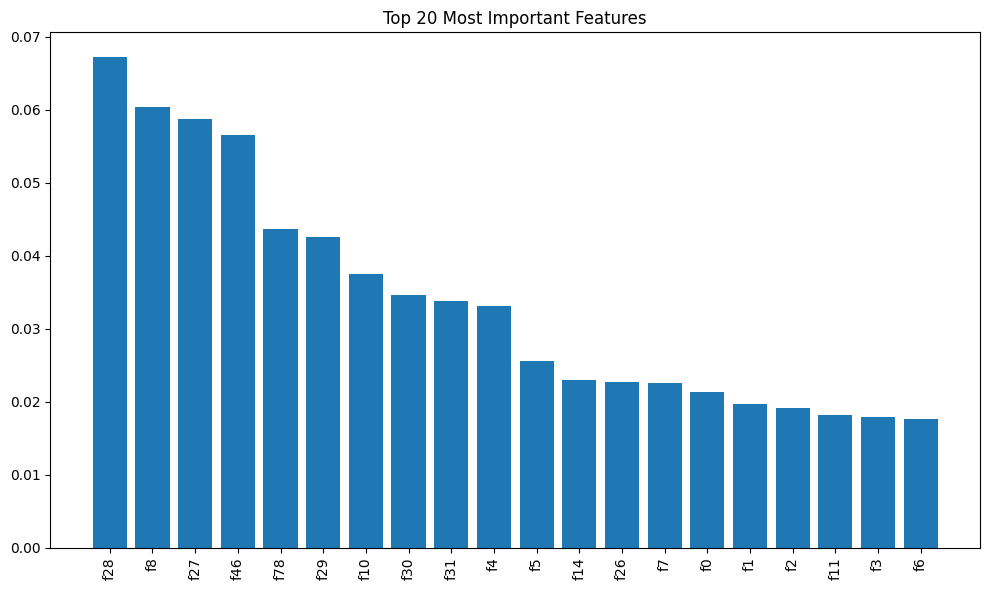

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Load model + features
model = joblib.load("final_model.pkl")
df = pd.read_csv("extended_features.csv")

# Drop unused columns
X = df.drop(["scanner", "filename"], axis=1)

# Get importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Show top 20 features
top_n = 20
top_features = X.columns[indices][:top_n]
top_scores = importances[indices][:top_n]

print("\nTop Important Features:")
for f, s in zip(top_features, top_scores):
    print(f"{f}: {s:.5f}")

# Plot
plt.figure(figsize=(10,6))
plt.bar(range(top_n), top_scores)
plt.xticks(range(top_n), top_features, rotation=90)
plt.title("Top 20 Most Important Features")
plt.tight_layout()
plt.show()